In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import textwrap
import random
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, Embedding, Conv1D, LSTM
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/API-KEYS/kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

## Importing Dataset

Dataset from [Kaggle IMDB Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download). Contains 50,000 moview reviews and sentiment labels for each review.

In [6]:
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

100% 25.7M/25.7M [00:01<00:00, 22.3MB/s]
100% 25.7M/25.7M [00:01<00:00, 14.5MB/s]


In [7]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [8]:
reviews = pd.read_csv('IMDB Dataset.csv')

Lets see what the reviews currently look like:

In [9]:
random_reviews = reviews.sample(n=3)
for index, row in random_reviews.iterrows():
    review = row['review']
    review_wrapped = textwrap.fill(review, width=80)
    print("Review:", review_wrapped)
    print("Sentiment:", row['sentiment'])
    print("-------------------------------------------------------------------------------------")

Review: Having previously seen the abridged print presented by David Shepard, I finally
got a hold of a complete--or nearer complete version, which was about 56 minutes
compared to the 30-minute version more widely distributed. The Shepard print for
Image Entertainment is certainly of superior quality, and the best parts are
there, but it's nonetheless good to see the rest of the film and fill in some
loose story ends.<br /><br />In the Shepard print, the film ends with Mary
stating, "You see, I've changed my mind--I'm never going home." Yet, in the
complete version, Mary and Kenneth Driscoll end their relationship soon after
that scene  Mary returns home to the country  and Driscoll rekindles his
relationship with Vivian. This additional footage develops the character Vivian,
who had little relevance in the Shepard version. Moreover, in the complete
version, the film begins in the New Jersey countryside with Mary, where she
reads and fantasizes about her ideal lover. She's disappoin

The reviews contain information that is irrelivant to the sentiment (commas, periods, HTML tags, etc.) and the sentiments are in an unusable form (string).



## Preprocessing

For our model to perform optimally we want tokenized reviews of a standard length that only contain words relevant to the sentiment, and sentiments in binary.

In [10]:
nltk.download('stopwords')

def preprocess(review):
  p_review = review.lower() # make all characters lowercase
  p_review = re.sub(r'<[^>]+>', ' ', p_review) # remove HTML tags
  p_review = re.sub('[^a-z]', ' ', p_review) # remove punctuation and numbers
  p_review = re.sub(r"\s+[a-zA-Z]\s+", ' ', p_review) # remove single characters
  p_review = re.sub(r"\s+", ' ', p_review) # remove multiple spaces
  pattern = re.compile(pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*'))
  p_review = pattern.sub('', p_review) # remove stopwords (e.g the, is, are, etc.)
  return p_review

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
X = []
for review in list(reviews['review']):
  X.append(preprocess(review))

y = reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y))) # converting sentiments to binary

Let's look at the reviews after preprocessing:

In [12]:
random_reviews = random.sample(X, 3)
for review in random_reviews:
    review_wrapped = textwrap.fill(review, width=80)
    print("Review:", review_wrapped)
    print("-------------------------------------------------------------------------------------")

Review: thunder alley finds fabian banned nascar tracks causing death another driver
stanley adams might want put team racers drivers around desperate employment
fabian hooks auto stunt show owner jan murray paying peanuts trying capitalize
fabian bad rep got take annette funicello murray daughter provides another
reason stick around rest film fabian struggle get back nascar circuit time
juggling annette current girl friend diane mcbain personally would taken mcbain
annette thunder alley helped location shooting southern nascar tracks good film
footage nascar racing helped rather silly story delves real reason fabian
problems rather unrealistic recovery still fans nascar might go
-------------------------------------------------------------------------------------
Review: real sudsy soap opera spencer tracy tackles role illiterate age marries woman
teaches ambition drive leads success success happiness n eer well son faltering
marriage leads disaster tragedy tracy buys railroad succeed

Now the reviews only contain information relevant to their sentiment.

Let's tokenize the reviews

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)

Now each word in the reviews is replaced with it's index in the vocabulary.

Let's standardize the review sizes

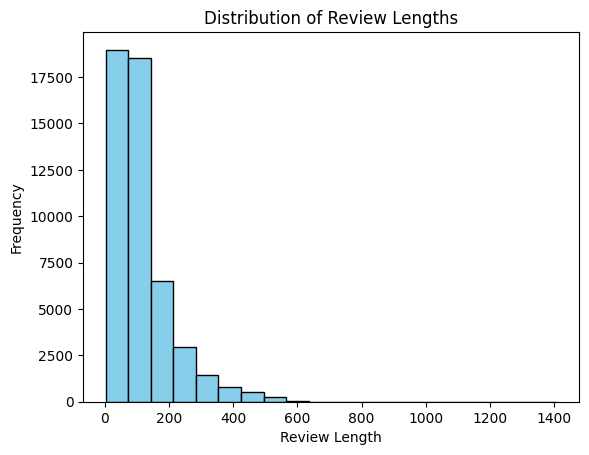

In [14]:
# check distribution of lengths
review_lengths = [len(review.split()) for review in X]

plt.hist(review_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

Most reviews are under 200 words so that seems like a good standard length

In [15]:
MAXLEN = 200
X = pad_sequences(X_tokenized, padding='post', maxlen=MAXLEN)

Let's also split the data into train and test sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

##Embedding

Now that we have our reviews in a usable format we want to embed the words into vectors of a standard size so that we can feed the resulting feature matrix to the model as input.

We will use GloVe pretrained embeddings from [the Stanford NLP Group](https://nlp.stanford.edu/projects/glove/)

In [17]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-04-08 03:47:00--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-08 03:47:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.14MB/s    in 2m 41s  

2024-04-08 03:49:42 (5.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

We'll use the 200 dimension vector GloVe vectors to create an embedding dictionary. First let's look at how the embeddings are formatted in the text file.

In [18]:
with open('/content/glove.6B.200d.txt', 'r') as file:
            for _ in range(10):
                line = file.readline()
                if not line:
                    break
                print(line, end='')

the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 -0.39796 -0.092139 0.061181 -0.1895 0.13061 0.14349 0.011479 0.38158 0.5403 -0.14088 0.24315 0.23036 -0.55339 0.048154 0.45662 3.2338 0.020199 0.049019 -0.014132 0.076017 -0.11527 0.2006 -0.077657 0.24328 0.16368 -0.34118 -0.06607 0.10152 0.038232 -0.17668 -0.88153 -0.33895 -0.035481 -0.55095 -0.016899 -0.43982 0.039004 0.40447 -0.2588 0.64594 0.26641 0.28009 -0.024625 0.63302 -0.317 0.10271 0.30886 0.097792 -0.38227 0.086552 0.047075 0.23511 -0.32127 -0.28538 0.1667 -0.0049707 -0.62714 -0.24904 0.29713 0.14379 -0.12325 -0.058178 -0.001029 -0.082126 0.36935 -0.00058442 0.34286 0.28426 -0.068599 0.65747 -0.029087 0.16184 0.073672 -0.30343 0.095733 -0.5286 -0.22898 0.064079 0.015218 0.34921 -0.4396 -0.43983 0.77515 -0.87767 -0.087504 0.39598 0.62362 -0.26211 -0.30539 -0.022964 0.30567 0.06766 0.15383 -0.11211 -0.09154 0.082562 0.16897 -0.032952 -0.28775 -0.2232 -0.090426 1.2407 -0.18244 -0.0075219 -0.041388 -0.011083 0.078186 0.3

The text file is formatted with space as a seperator and each line serving as a record, the first column has the words and the subsequent columns have the embedding.

We can create an embedding dictionary from this text file to make using the embeddings easier.

In [19]:
embeddings_dict = dict()
glove_file = open('/content/glove.6B.200d.txt')
for line in glove_file:
  records = line.split()
  word = records[0]
  vector = np.asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector
glove_file.close()

Next we want to create our embedding/feature matrix. This is a $|V|\times d$ matrix containing the embedding for each word in our corpus.

In [20]:
len(tokenizer.word_index) # number of unique words in our corpus

99267

So in our dataset we have 99,267 words in our vocabulary, we'll add 1 to this number to account for any out of vocabulary words later on (they'll have embedding of 0) and use that number as our $|V|$.

In [21]:
vocab_len = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_len, 200))
for word, index in tokenizer.word_index.items():
  vector = embeddings_dict.get(word)
  if vector is not None:
    embedding_matrix[index] = vector

embedding_matrix.shape

(99268, 200)

## Training

For sentiment analysis (a text classification task), there are multiple models that are likely to do well.

We'll be training 3 models and comparing between their performance:

1. Forward Feed Neural Network (FFNN)/ Artificial Neural network (ANN)
2. Convulutional Neural Network (CNN) as outlined in [this paper](https://journal.ugm.ac.id/ijitee/article/viewFile/36642/21340)
3. Bidirectional Long Short Term Memory (LSTM) Neural Network as outlined in [this paper](https://doi.org/10.1016/j.procs.2022.12.400)

The FFN/ANN is only included as a kind of baseline model for comparison's sake.

### Forward Feed Neural Network (FFNN)/ Artificial Neural network (ANN)

The network architecture will consist of:
- An embedding layer
- A dense layer
- A flatten layer
- An output layer.

The embedding layer will use the embedding matix we built previously. The dense layer will consisit of 128 (arbitrary) units and will use a ReLU activation function. The final output layer will use Sigmoid activation to map the results to a binary value.

In [22]:
ann_model = Sequential()
embedding_layer = Embedding(vocab_len, 200, weights=[embedding_matrix], input_length=200, trainable=False)
ann_model.add(embedding_layer)

ann_model.add(Dense(128, activation='relu'))
ann_model.add(Flatten())
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(ann_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          19853600  
                                                                 
 dense (Dense)               (None, 200, 128)          25728     
                                                                 
 flatten (Flatten)           (None, 25600)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 19904929 (75.93 MB)
Trainable params: 51329 (200.50 KB)
Non-trainable params: 19853600 (75.74 MB)
_________________________________________________________________
None


In [23]:
ann_model_history = ann_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 5s 7ms/step - loss: 0.4890 - acc: 0.7603 - val_loss: 0.3899 - val_acc: 0.8336
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3319 - acc: 0.8605 - val_loss: 0.3523 - val_acc: 0.8531
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2681 - acc: 0.8920 - val_loss: 0.3704 - val_acc: 0.8489
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2109 - acc: 0.9215 - val_loss: 0.4169 - val_acc: 0.8295
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.1732 - acc: 0.9395 - val_loss: 0.3917 - val_acc: 0.8450
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.1360 - acc: 0.9570 - val_loss: 0.3985 - val_acc: 0.8521


In [24]:
y_pred_prob = ann_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [25]:
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4961
           1       0.84      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



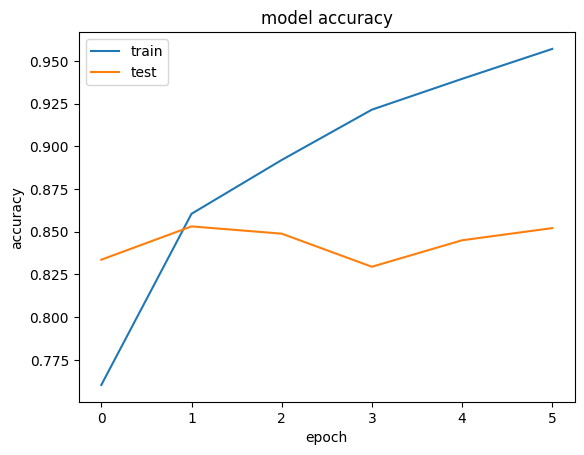

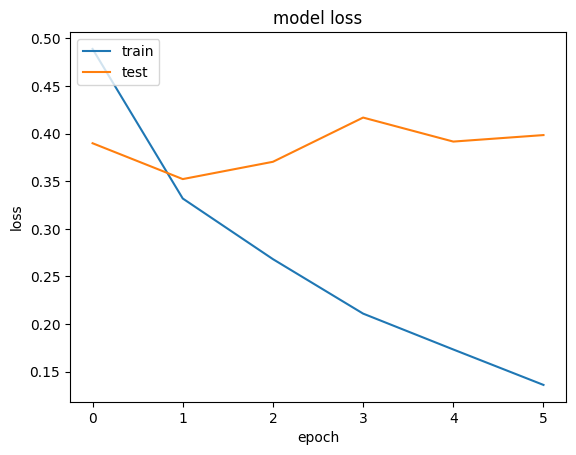

In [26]:
plt.plot(ann_model_history.history['acc'])
plt.plot(ann_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(ann_model_history.history['loss'])
plt.plot(ann_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Convolutional Neural Network (CNN)

The network architecture used will be as described in the reference paper as "Setting III" with an adjustment made to the embedding dimensions.

The architecture will consist of:
- An embedding layer
- Three convolutional layers with filter sizes 2, 3, and 4, each having 100 filters
- Max pooling layers after each convolutional layer
- Dropout regularization with a rate of 0.5 after each convolutional layer
- L2 regularization with a regularization strength of 0.5
- Dense layers for classification


In [27]:
# parameters
filter_sizes = [2, 3, 4]
num_filters = 100
dropout_rate = 0.5
l2_regularization = 0.5

In [28]:
cnn_model = Sequential()
embedding_layer = Embedding(vocab_len, 200, weights=[embedding_matrix], input_length=200, trainable=False)
cnn_model.add(embedding_layer)

for filter_size in filter_sizes:
    cnn_model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
    cnn_model.add(MaxPooling1D())
    cnn_model.add(Dropout(rate=dropout_rate))

cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_regularization)))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          19853600  
                                                                 
 conv1d (Conv1D)             (None, 199, 100)          40100     
                                                                 
 max_pooling1d (MaxPooling1  (None, 99, 100)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 97, 100)           30100     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 48, 100)           0         
 g1D)                                                 


Durning training the researchers used a batch size of 50.

Early stopping based on validation loss will be used to determine the optimal number of epochs.

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [30]:
cnn_model_history = cnn_model.fit(X_train, y_train,
                                  batch_size=50,
                                  epochs=15,
                                  verbose=1,
                                  validation_split=0.2,
                                  callbacks=[early_stopping])

Epoch 1/15
640/640 [==============================] - 9s 7ms/step - loss: 4.7383 - accuracy: 0.7411 - val_loss: 0.5065 - val_accuracy: 0.8359
Epoch 2/15
640/640 [==============================] - 4s 7ms/step - loss: 0.3954 - accuracy: 0.8354 - val_loss: 0.4234 - val_accuracy: 0.8560
Epoch 3/15
640/640 [==============================] - 5s 7ms/step - loss: 0.3708 - accuracy: 0.8469 - val_loss: 0.4009 - val_accuracy: 0.8601
Epoch 4/15
640/640 [==============================] - 4s 6ms/step - loss: 0.3488 - accuracy: 0.8580 - val_loss: 0.3850 - val_accuracy: 0.8660
Epoch 5/15
640/640 [==============================] - 3s 5ms/step - loss: 0.3361 - accuracy: 0.8630 - val_loss: 0.3878 - val_accuracy: 0.8616
Epoch 6/15
640/640 [==============================] - 3s 5ms/step - loss: 0.3262 - accuracy: 0.8713 - val_loss: 0.3735 - val_accuracy: 0.8601
Epoch 7/15
640/640 [==============================] - 3s 5ms/step - loss: 0.3144 - accuracy: 0.8755 - val_loss: 0.3693 - val_accuracy: 0.8546
Epoch 

In [31]:
y_pred_prob = cnn_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [32]:
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4961
           1       0.82      0.92      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



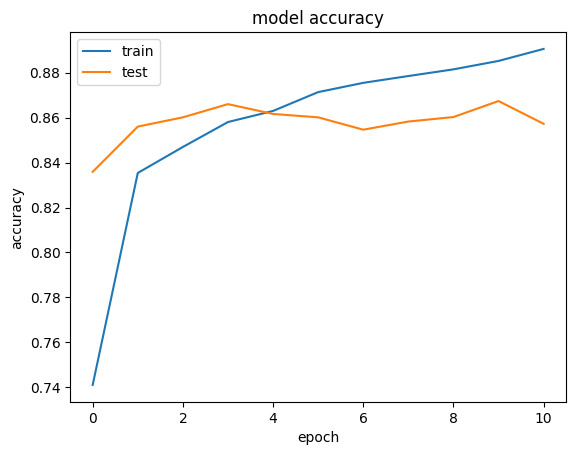

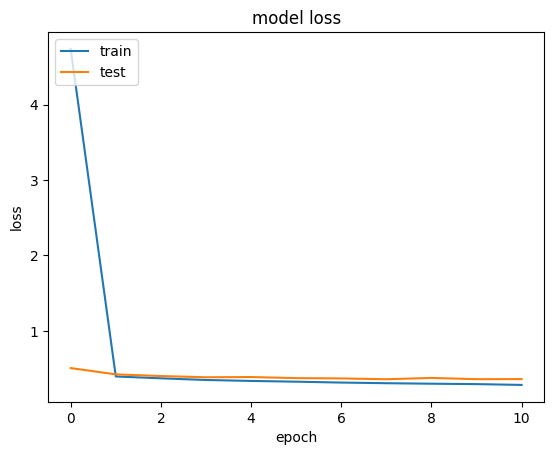

In [33]:
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Bidirectional Long Short Term Memory (LSTM) Neural Network

The network architecture used will be as described in the reference paper.

The architecture will consit of:
- An embedding layer
- Two Bidirectional LSTM layers with 128 units each
- Three Dense layers with ReLU activation function, each followed by a Dropout layer with a dropout rate of 0.5
- An output Dense layer with a sigmoid activation function


In [34]:
bi_lstm_model = Sequential()

embedding_layer = Embedding(vocab_len, 200, weights=[embedding_matrix], input_length=200, trainable=False)
bi_lstm_model.add(embedding_layer)

bi_lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(128)))

bi_lstm_model.add(Dense(64, activation='relu'))
bi_lstm_model.add(Dropout(0.5))
bi_lstm_model.add(Dense(64, activation='relu'))
bi_lstm_model.add(Dropout(0.5))
bi_lstm_model.add(Dense(16, activation='relu'))
bi_lstm_model.add(Dropout(0.5))

bi_lstm_model.add(Dense(1, activation='sigmoid'))


bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(bi_lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          19853600  
                                                                 
 bidirectional (Bidirection  (None, 200, 256)          336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)               

During training the researchers used a batch size of 128, which will be adjusted to a batch size of 50 due to our relatively smaller dataset.

Early stopping based on validation loss will be used to determine the optimal number of epochs.

In [35]:
bi_lstm_model_history = bi_lstm_model.fit(X_train, y_train,
                                  batch_size=50,
                                  epochs=15,
                                  verbose=1,
                                  validation_split=0.2,
                                  callbacks=[early_stopping])

Epoch 1/15
640/640 [==============================] - 39s 49ms/step - loss: 0.6258 - accuracy: 0.6391 - val_loss: 0.6594 - val_accuracy: 0.7536
Epoch 2/15
640/640 [==============================] - 33s 52ms/step - loss: 0.6094 - accuracy: 0.6814 - val_loss: 0.5830 - val_accuracy: 0.6770
Epoch 3/15
640/640 [==============================] - 28s 43ms/step - loss: 0.4634 - accuracy: 0.8049 - val_loss: 0.3791 - val_accuracy: 0.8459
Epoch 4/15
640/640 [==============================] - 27s 42ms/step - loss: 0.4000 - accuracy: 0.8411 - val_loss: 0.3235 - val_accuracy: 0.8639
Epoch 5/15
640/640 [==============================] - 27s 42ms/step - loss: 0.3635 - accuracy: 0.8595 - val_loss: 0.3130 - val_accuracy: 0.8710
Epoch 6/15
640/640 [==============================] - 26s 41ms/step - loss: 0.3570 - accuracy: 0.8605 - val_loss: 0.2942 - val_accuracy: 0.8779
Epoch 7/15
640/640 [==============================] - 27s 42ms/step - loss: 0.3205 - accuracy: 0.8765 - val_loss: 0.2949 - val_accuracy:

In [36]:
y_pred_prob = bi_lstm_model.predict(X_test)

313/313 [==============================] - 8s 14ms/step


In [37]:
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4961
           1       0.90      0.85      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



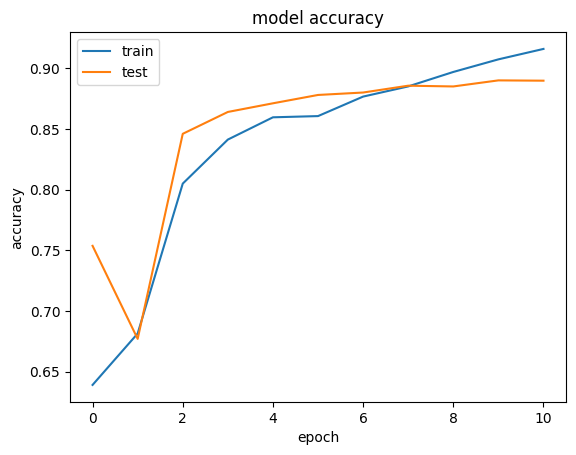

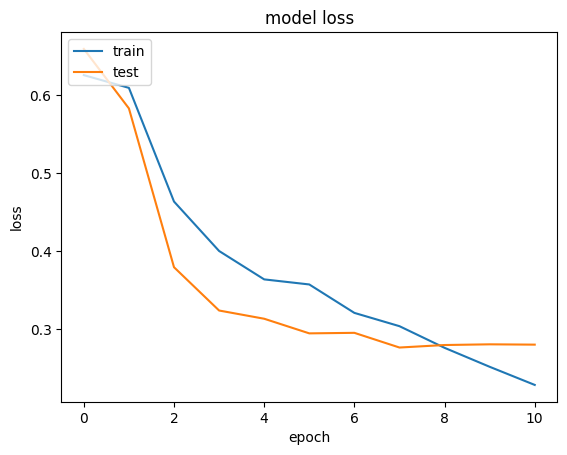

In [38]:
plt.plot(bi_lstm_model_history.history['accuracy'])
plt.plot(bi_lstm_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(bi_lstm_model_history.history['loss'])
plt.plot(bi_lstm_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Conclusion

The clear winner in terms of performance is the Bidirectional LSTM model. However, it is a more complex and time consuming model to train, especially when considering the relatively small increase in accuracy when compared to simpler models like CNN or ANN.
